In [1]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re

In [3]:
# # Use Hannah's code to filter "Patches" folder to keep only relevant images (filter out non-patch images and patches that are too small)
# # Saves resulting patches into "filtered_patches" folder - ONLY NEED TO RUN ONCE

# #Define filtering function
# def filter(input_folder, output_base_folder):
#     # Make sure input folder exists
#     if not os.path.isdir(input_folder):
#         print(f"Error: {input_folder} is not a valid directory.")
#         return

#     # Create the output base folder if it doesn't exist
#     os.makedirs(output_base_folder, exist_ok=True)

#     # Iterate over each item in the input folder
#     for item in os.listdir(input_folder):
#         item_path = os.path.join(input_folder, item)
#         if "patched_" in item_path or item_path[-3:] == 'tif' or os.path.isdir(item_path):
#             pass
#         else:
#             size = os.stat(item_path).st_size
#             if size > 2000 and bool(re.search("patch\d{1,3}", item_path)):
#                 shutil.copy(item_path, output_base_folder)
#                 # print(f"Copied '{item}' to '{output_base_folder}'")

# # call function - modify folder paths if needed !!!
# if __name__ == "__main__":
#     input_folder = '/content/drive/My Drive/Patches'
#     output_base_folder = '/content/drive/My Drive/filtered_patches'

#     filter(input_folder, output_base_folder)

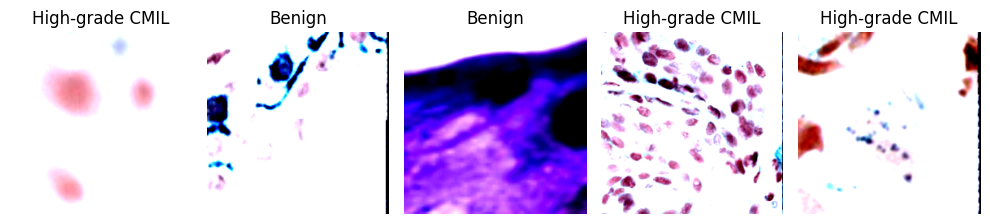

In [4]:
# Add labels to each patch and match by their case, randomly split patients into training, validation, and testing sets

labels = pd.read_csv('/content/drive/My Drive/case_grade_match.csv') # Replace with the path to file

# Define a function to group patches by case number
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)  # Using regex for case number extraction
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

# Define a custom dataset class for loading PNG images
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Label benign images 0, and high-grade CMIL images 1
        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Get patch images
        image = Image.open(image_path).convert('RGB')
        # Get the label information using the labels dataframe based on case number
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Resize all patch images to 256x256
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Possible data augmentation for training data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_folder_path = '/content/drive/My Drive/filtered_patches' # Replace with the path to filtered patches
patches = group_patches(image_folder_path)

# Get case numbers and their labels
case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

# Remove those that are equal to 2 (not classifying low-grade CMIL images currently)
noindex = dataset.Class != 2.0
X = dataset[noindex].Case
y = dataset[noindex].Class

# Ensure X and y have the same length before splitting
X = X.reset_index(drop=True)  # Reset index to avoid potential issues
y = y.reset_index(drop=True)  # Reset index to avoid potential issues

# Split the data into train, test, and validation sets
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Create the training, validation, and testing patches
train_patches = {case_num: patches[int(case_num)] for case_num in train_X} # Use train_X
val_patches = {case_num: patches[int(case_num)] for case_num in val_X} # Use val_X
test_patches = {case_num: patches[int(case_num)] for case_num in test_X} # Use test_X

# Create PNGDataset instances for train, validation, and test
train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=transform)
test_dataset = PNGDataset(test_patches, labels, transform=transform)

# Create DataLoaders using the PNGDataset instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())  # Shuffle validation data ### I DONT THINK THIS IS NEEDED
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count()) # Do not shuffle test data

# Visualize first few images in training set
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [5]:
# def validation(model, criterion, val_loader):
#     val_loss = 0
#     accuracy = 0

#     for images, labels in iter(val_loader):
#         output = model.forward(images)
#         val_loss += criterion(output, labels).item()

#         probabilities = torch.exp(output) # SHOULD NOT USE, the last linear layer outputs raw logits not log probabilities (LogSoftMax)

#         equality = labels.data == probabilities.max(dim=1)[1]
#         accuracy += equality.type(torch.FloatTensor).mean()

#     return val_loss, accuracy
def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in iter(val_loader):
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item() * images.size(0)  # ✅ Scale by batch size

            _, preds = torch.max(output, dim=1)
            correct = (preds == labels).sum().item()
            correct_total += correct
            sample_total += labels.size(0)

    accuracy = correct_total / sample_total
    val_loss /= sample_total  # ✅ Now compute the proper average
    return val_loss, accuracy
  # Define training loop

# ---------- Checkpoint Save Function ----------
def save_checkpoint(model, arch, checkpoint_dir, epoch):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"

    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }

    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved: {filename}")

# ---------- Training Function ----------
def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5, start_epoch=0):
    plot_training = []
    plot_validation = []

    for e in range(start_epoch, start_epoch + epochs):
        model.train()
        running_loss = 0

        for images, labels in iter(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # Validation
        validation_loss, accuracy = validation(model, criterion, val_loader)

        print(
            f"Epoch: {e + 1}/{epochs}.. "
            f"Training Loss: {epoch_loss:.3f}.. "
            f"Validation Loss: {validation_loss:.3f}.. "
            f"Validation Accuracy: {accuracy:.3f}"
        )

        plot_training.append(epoch_loss)
        plot_validation.append(validation_loss)

        # Save checkpoint
        save_checkpoint(model, arch, checkpoint_dir, epoch=e + 1)

    # Plot training & validation loss
    plt.plot(range(1, epochs + 1), plot_training, label='Training Loss')
    plt.plot(range(1, epochs + 1), plot_validation, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return model


In [6]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import os

# Load ResNet-18 with pretrained weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)
arch = "resnet50"

checkpoint_dir = "/content/drive/My Drive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# # ✅ Freeze all convolutional layers (optional)
# for param in model.parameters():
#     param.requires_grad = False

# # ✅ Unfreeze just the final FC layer (optional)
# for param in model.fc.parameters():
#     param.requires_grad = True

# ✅ Replace the final fully connected layer
num_classes = 2
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Confirm the final layer
print("\nModified final layer:")
print(model.fc)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.7MB/s]


Modified final layer:
Linear(in_features=2048, out_features=2, bias=True)


In [7]:
# Loss function and gradient descent
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [8]:
checkpoint_path = "/content/drive/My Drive/checkpoints/20250416_074323_resnet50_epoch1.pth"
checkpoint = torch.load(checkpoint_path)

model = models.resnet50(weights=None)  # We will load weights manually
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint["epoch"]


In [ ]:
# resnet_model = train_model(
#     model=model,
#     optimizer=optimizer,
#     criterion=criterion,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     arch=arch,
#     checkpoint_dir=checkpoint_dir,
#     epochs=5,            # how many *more* epochs to train
#     start_epoch=0  # where you left off
# )

Epoch: 1/5.. Training Loss: 0.478.. Validation Loss: 0.703.. Validation Accuracy: 0.683
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250416_074323_resnet50_epoch1.pth
Epoch: 2/5.. Training Loss: 0.440.. Validation Loss: 0.725.. Validation Accuracy: 0.639
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250416_100328_resnet50_epoch2.pth
Epoch: 3/5.. Training Loss: 0.424.. Validation Loss: 0.715.. Validation Accuracy: 0.669
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250416_122329_resnet50_epoch3.pth
Epoch: 4/5.. Training Loss: 0.408.. Validation Loss: 0.781.. Validation Accuracy: 0.664
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250416_144656_resnet50_epoch4.pth


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/filtered_patches/case_002_match_1_melan_patch9.png'

In [9]:
model.eval()

with torch.no_grad():
    predictions = []
    true_labels = []

    for images, labels in iter(test_loader):
        output = model.forward(images)
        probabilities = torch.exp(output)
        predictions += probabilities.max(dim=1)[1].tolist()
        true_labels += labels.tolist()

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.48      0.35      0.40       572
           1       0.86      0.92      0.89      2586

    accuracy                           0.81      3158
   macro avg       0.67      0.63      0.65      3158
weighted avg       0.79      0.81      0.80      3158



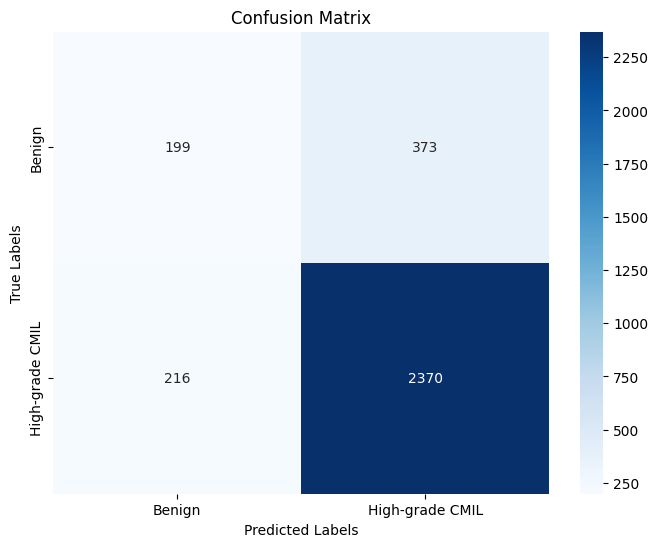

In [10]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [11]:
# Get accuracies for individual cases in the test set

case_predictions = {}
case_true_labels = {}
case_accuracies = {}

# Create a dictionary to map image paths to case numbers
image_to_case = {}
for case_num, patches in test_patches.items():
    for patch in patches:
        image_to_case[patch] = case_num

# Iterate through the test dataset to map predictions back to case numbers
for i in range(len(test_dataset)):
    image_path, label = test_dataset[i]  # Access the image path and label directly from the dataset
    case_num = image_to_case[test_dataset.image_paths[i]]  # Use the image path to find the case number
    prediction = predictions[i]  # Access the prediction directly from the prediction list

    if case_num not in case_predictions:
        case_predictions[case_num] = []
        case_true_labels[case_num] = []
    case_predictions[case_num].append(prediction)
    case_true_labels[case_num].append(label)

for case_num, preds in case_predictions.items():
    correct_count = sum(1 for p, t in zip(preds, case_true_labels[case_num]) if p == t)
    accuracy = (correct_count / len(preds)) if len(preds) > 0 else 0  # Avoid division by zero
    case_accuracies[case_num] = accuracy

# Print the results
for case_num, accuracy in case_accuracies.items():
    true_label = case_true_labels[case_num][0]  # Get the true label for the case (all labels should be the same for a single case)
    true_label_name = 'Benign' if true_label == 0 else 'High-grade CMIL'  # Convert to label name
    print(f"Case {case_num}: Accuracy = {accuracy:.4f}, True Label = {true_label_name}")

Case 1: Accuracy = 0.9778, True Label = High-grade CMIL
Case 86: Accuracy = 0.9406, True Label = High-grade CMIL
Case 32: Accuracy = 0.8777, True Label = High-grade CMIL
Case 15: Accuracy = 0.8233, True Label = High-grade CMIL
Case 45: Accuracy = 0.0417, True Label = Benign
Case 63: Accuracy = 0.9167, True Label = High-grade CMIL
Case 43: Accuracy = 0.0000, True Label = Benign
Case 84: Accuracy = 0.0543, True Label = Benign
Case 69: Accuracy = 0.8772, True Label = High-grade CMIL
Case 66: Accuracy = 0.9207, True Label = High-grade CMIL
Case 95: Accuracy = 0.0000, True Label = Benign
Case 101: Accuracy = 0.9836, True Label = High-grade CMIL
Case 94: Accuracy = 0.9487, True Label = High-grade CMIL
Case 26: Accuracy = 0.5543, True Label = Benign
Case 44: Accuracy = 1.0000, True Label = High-grade CMIL
Case 24: Accuracy = 0.4842, True Label = Benign
Case 60: Accuracy = 0.9318, True Label = High-grade CMIL
Case 33: Accuracy = 0.8301, True Label = High-grade CMIL
